## **Train R-CNN model 💪**

*This notebook was created with the code from [this](https://github.com/shashankag14/fine-tune-object-detector/blob/main/fine_tune.ipynb) notebook by shashankag14, [this](https://www.kaggle.com/code/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook) notebook by yerramvarun and [this](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-your-model) Faster R-CNN pytorch tutorial*

### **Imports**

In [1]:
from helper_functions import *
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


# **Dataset**

### **Data augmentation**
Only applied to traning data

In [2]:
transform = A.Compose([
            A.HorizontalFlip(0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.05, 0.05)),
            ToTensorV2(p=1.0)
            ],
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### **Define training and validation loaders**

In [3]:
DATA_FOLDER = r'./fashion_v1/yolo'
CLASSES = ['bg', 'Hole', 'Stain', 'TUD']
IMG_WIDTH = 1280
IMG_HEIGHT = 720
TRAIN_DATA = "train_damaged"
VAL_DATA = "val"

train_dataset = FashionDataset(
    data_folder=DATA_FOLDER,
    split=TRAIN_DATA, 
    width=IMG_WIDTH, height=IMG_HEIGHT,
    transform=transform)

val_dataset = FashionDataset(
    data_folder=DATA_FOLDER,
    split=VAL_DATA,
    width=IMG_WIDTH, height=IMG_HEIGHT)

print(f"Training data has {len(train_dataset)} sample{'s' if len(train_dataset)>1 else ''}.")
print(f"Validation data has {len(val_dataset)} sample{'s' if len(val_dataset)>1 else ''}.")

Training data has 1 sample.
Validation data has 1 sample.


**Plot a sample of the data to check everything is ok!**

Shapes:
Image: torch.Size([3, 720, 1280]) [C, H, W]
Boxes: torch.Size([5, 4]) [N, 4]
Labels: torch.Size([5]) [N]

Sample:
Boxes: tensor([[920.6201, 106.5402, 929.3203, 113.4400],
        [983.6902, 423.9295, 991.7901, 431.5298],
        [917.7203, 271.6402, 928.8205, 275.9400],
        [670.1696, 318.7602, 676.2701, 325.8601],
        [227.3805, 290.0999, 410.5203, 444.6198]])
Lables: tensor([3, 3, 3, 3, 2])
Actual labels: ['TUD', 'TUD', 'TUD', 'TUD', 'Stain']


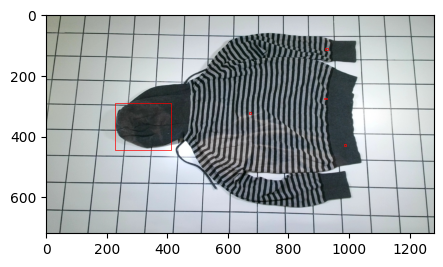

In [4]:
# Plot a sample!
img, target = train_dataset[0]
print("Shapes:")
print(f"Image: {img.shape} [C, H, W]")
print(f"Boxes: {target['boxes'].shape} [N, 4]")
print(f"Labels: {target['labels'].shape} [N]")

print("\nSample:")
print(f"Boxes: {target['boxes']}")
print(f"Lables: {target['labels']}")
print(f"Actual labels: {[CLASSES[i] for i in target['labels']]}")
plot_img_bbox(img, target)

### **Data loaders**

In [5]:
BATCH_SIZE = 2
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4,
    collate_fn=utils.utils.collate_fn)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16,
    shuffle=False, num_workers=4,
    collate_fn=utils.utils.collate_fn)

# **Model**

In [6]:
BOX_NMS = 0.5 # Default = 0.5
BOX_SCORE = 0.05 # Default = 0.05
BACKBONE_TRAIN_LAYERS = 5 # Default = 3

model = get_object_detection_model(num_classes=len(CLASSES), # 3 classes + background
                                   trainable_backbone_layers = BACKBONE_TRAIN_LAYERS,
                                   box_nms_thresh=BOX_NMS,
                                   box_score_thresh = BOX_SCORE)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### **Preparing to train model**

In [7]:
LR_TYPE = "SGD + wgt decay + lr_scheduler"
LR = 0.002

MOMENTUM = 0.95
WEIGHT_DECAY = 0.005
LR_STEP_SIZE = 5
LR_GAMMA = 0.5

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)
save_each_epoch = False

### **Train model**

In [8]:
#os.environ['WANDB_NOTEBOOK_NAME'] = "train_FasterRCNN.ipynb"
NUM_EPOCHS = 100
MODEL_NAME = get_mod_name(model)
history = []
best_val_loss = np.inf
PATIENCE = 8
early_stopping = EarlyStoppingLoss(patience=PATIENCE)

os.makedirs(f'runs/{MODEL_NAME}', exist_ok=False)
if save_each_epoch:
    os.makedirs(f'runs/{MODEL_NAME}/epochs')

#config = {
#    "learning_rate": {
#        "type": LR_TYPE,
#        "lr": LR,
#        "momentum": MOMENTUM,
#        "weight_decay": WEIGHT_DECAY,
#        "lr_step_size": LR_STEP_SIZE,
#        "lr_gamma": LR_GAMMA
#    },
#    "train_data": TRAIN_DATA,
#    "val_data": VAL_DATA,
#    "batch_size": BATCH_SIZE,
#    "max_epochs": NUM_EPOCHS,
#    "early_stopping_patience": PATIENCE,
#    "box_nms" : BOX_NMS,
#    "box_conf_score" : BOX_SCORE,
#    "trainable_backbone_layes" : BACKBONE_TRAIN_LAYERS
#}

#if transform is not None:
#    config["augmentation"] = transform.to_dict()


#wandb.init(
#    project='FasterRCNN',
#    save_code=True,
#    name=MODEL_NAME,
#    entity='leonnorblad',
#    config=config
#)

train_losses = {
    'loss': [],
    'loss_classifier': [],
    'loss_box_reg': [],
    'loss_objectness': [],
    'loss_rpn_box_reg': []
}

val_losses = {
    'loss': [],
    'loss_classifier': [],
    'loss_box_reg': [],
    'loss_objectness': [],
    'loss_rpn_box_reg': []
}

for epoch in range(NUM_EPOCHS):
    # Training for one epoch
    train_metrics = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=1000)
    lr_epoch = train_metrics.meters['lr'].value
    # train_metrics: dict with keys: 'lr', 'loss', 'loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'
    
    # Validate epoch
    val_metrics = get_val_loss(model, val_loader, device, print_freq=1000)
    val_loss_epoch = val_metrics.meters['loss'].value
    # val_metrics: dict with keys: 'loss', 'loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'

    # update the learning rate
    lr_scheduler.step()
    
    # WandB logging
    #for loss_type in train_losses:
    #    train_losses[loss_type].append(train_metrics.meters[loss_type].value)
    #    wandb.log({f'Train_{loss_type.capitalize()}': train_metrics.meters[loss_type].value})
    
    #for loss_type in val_losses:
    #    val_losses[loss_type].append(val_metrics.meters[loss_type].value)
    #    wandb.log({f'Val_{loss_type.capitalize()}': val_metrics.meters[loss_type].value})

    #wandb.log({"lr_epoch": lr_epoch})

    # Save best model
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), f"runs/{MODEL_NAME}/best.pth")

    ## Early stopping
    early_stopping(val_loss_epoch)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch: {epoch+1}")
        break

    if save_each_epoch:
        torch.save(model.state_dict(), f'runs/{MODEL_NAME}/epochs/{epoch+1}.pth')

# Save latest model (not best)
torch.save(model.state_dict(), f'runs/{MODEL_NAME}/last.pth')

# Save evaluation metric for best epoch

# Load model of best epoch
model = get_object_detection_model(num_classes=len(CLASSES))
model.load_state_dict(torch.load(f"runs/{MODEL_NAME}/best.pth"))
model.to(device)

# Evaluate best model
#res30 = ValidationMetric(model, val_loader, device, iou_thresholds=[0.3]).compute_mAP()
#res50 = ValidationMetric(model, val_loader, device, iou_thresholds=[0.5]).compute_mAP()
#res = ValidationMetric(model, val_loader, device).compute_mAP()

#hole_met = {"mAP@[.5; .05; .95]":res['map_per_class'][0],
#            "mAP@50":res50['map_per_class'][0],
#            "mAP@30":res30['map_per_class'][0]}

#stain_met = {"mAP@[.5; .05; .95]":res['map_per_class'][1],
#            "mAP@50":res50['map_per_class'][1],
#            "mAP@30":res30['map_per_class'][1]}

#TUD_met = {"mAP@[.5; .05; .95]":res['map_per_class'][2],
#            "mAP@50":res50['map_per_class'][2],
#            "mAP@30":res30['map_per_class'][2]}

#small_met ={"mAP@[.5; .05; .95]":res['map_small'],
#            "mAP@50":res50['map_small'],
#            "mAP@30":res30['map_small']}

#medium_met ={"mAP@[.5; .05; .95]":res['map_medium'],
#            "mAP@50":res50['map_medium'],
#            "mAP@30":res30['map_medium']}

#large_met ={"mAP@[.5; .05; .95]":res['map_large'],
#            "mAP@50":res50['map_large'],
#            "mAP@30":res30['map_large']}


#eval_met = {"Hole":hole_met,
#             "Stain":stain_met,
#             "TUD":TUD_met,
#            "Small":small_met,
#            "Medium:":medium_met,
#            "Large":large_met,
#            "mAP@[.5; .05; .95]":res['map'],
#            "mAP@50":res50['map'],
#            "mAP@30":res30['map']}

#wandb.log(eval_met)
#wandb.log({"final epoch":epoch+1})
#wandb.finish()

# Save history
training_history = {"train":train_losses, "val":val_losses}
with open(f'runs/{MODEL_NAME}/history.json', "w") as json_file:
    json.dump(training_history, json_file)

Epoch: [0]  [0/1]  eta: 0:00:01  lr: 0.000002  loss: 13.8372 (13.8372)  loss_classifier: 1.5447 (1.5447)  loss_box_reg: 0.1506 (0.1506)  loss_objectness: 10.8981 (10.8981)  loss_rpn_box_reg: 1.2438 (1.2438)  time: 1.6724  data: 0.1617  max mem: 1718
Epoch: [0] Total time: 0:00:01 (1.6969 s / it)
Validation:  [0/1]  eta: 0:00:00  loss: 3.4690 (3.4690)  loss_classifier: 1.5419 (1.5419)  loss_box_reg: 0.0018 (0.0018)  loss_objectness: 1.8862 (1.8862)  loss_rpn_box_reg: 0.0390 (0.0390)  time: 0.2651  data: 0.1633  max mem: 1718
Validation: Total time: 0:00:00 (0.3260 s / it)
Val loss improved! from inf, to: 3.468977689743042, Saving model weights :)

Epoch: [1]  [0/1]  eta: 0:00:00  lr: 0.000002  loss: 12.9148 (12.9148)  loss_classifier: 1.5468 (1.5468)  loss_box_reg: 0.1477 (0.1477)  loss_objectness: 9.8667 (9.8667)  loss_rpn_box_reg: 1.3536 (1.3536)  time: 0.2459  data: 0.1571  max mem: 1874
Epoch: [1] Total time: 0:00:00 (0.2828 s / it)
Validation:  [0/1]  eta: 0:00:00  loss: 3.4769 (3.